# Debugging autoreload

In [ ]:
%load_ext autoreload
%autoreload 2

# Load packages

In [1]:
from pytorch_tabular.utils import load_covertype_dataset
from rich.pretty import pprint
from sklearn.model_selection import BaseCrossValidator, ParameterGrid, ParameterSampler
import torch
import pickle
import shutil
from scipy import stats
import shap
from sklearn.model_selection import RepeatedStratifiedKFold
from glob import glob
import ast
import matplotlib.pyplot as plt
import seaborn as sns
import copy
import itertools
from sklearn.model_selection import train_test_split
import numpy as np
from pytorch_tabular.utils import make_mixed_dataset, print_metrics
from pytorch_tabular import available_models
from pytorch_tabular import TabularModel
from pytorch_tabular.models import CategoryEmbeddingModelConfig, GANDALFConfig, TabNetModelConfig, FTTransformerConfig, DANetConfig
from pytorch_tabular.config import DataConfig, OptimizerConfig, TrainerConfig
from pytorch_tabular.models.common.heads import LinearHeadConfig
from pytorch_tabular.tabular_model_tuner import TabularModelTuner
from torchmetrics.functional.regression import mean_absolute_error, pearson_corrcoef
from pytorch_tabular import MODEL_SWEEP_PRESETS
import pandas as pd
from pytorch_tabular import model_sweep
from src.pt.model_sweep import model_sweep_custom
import warnings
from src.utils.configs import read_parse_config
from src.pt.hyper_opt import train_hyper_opt
from src.utils.hash import dict_hash
import pathlib
from tqdm import tqdm
import distinctipy
import matplotlib.patheffects as pe
import matplotlib.colors as mcolors
from statannotations.Annotator import Annotator
from scipy.stats import mannwhitneyu
from plottable import ColumnDefinition, Table
from plottable.plots import bar
from plottable.cmap import normed_cmap, centered_cmap
import optuna
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.cm
import matplotlib as mpl
from statsmodels.stats.multitest import multipletests
import re
import datetime
from collections import Counter

def make_rgb_transparent(rgb, bg_rgb, alpha):
    return [alpha * c1 + (1 - alpha) * c2 for (c1, c2) in zip(rgb, bg_rgb)]

def form_bar(base):
    def formatter(x):
        return f'{str(int(round(x * base)))}/{base}'
    return formatter


# Load data

In [2]:
path = f"D:/YandexDisk/Work/bbd/fmba"
path_save = f"{path}/01_test_data"

# data_raw = pd.read_excel(f"{path}/2024-08-30 Пример 1000 за 2023 г в формате широких данных.xlsx", index_col=0)
data_raw = pd.read_excel(f"{path}/2024-10-11 1114 за 2023 г в формате широких данных.xlsx", index_col=0)
data = data_raw

# NaNs analysis

In [3]:
nan_pct = data.isna().sum().sum() / data.size * 100
print(nan_pct)

39.217187099256215


In [4]:
nan_feats = data.isna().sum(axis=0).to_frame(name="Number of NaNs")
nan_feats["% of NaNs"] = nan_feats["Number of NaNs"] / data.shape[0] * 100
nan_feats["Number of not-NaNs"] = data.notna().sum(axis=0)
nan_feats.sort_values(["% of NaNs"], ascending=[False], inplace=True)
nan_feats.to_excel(f"{path_save}/nan_feats.xlsx", index_label="Features")

# Age and sex analysis

c:\Users\user\anaconda3\envs\py311\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\user\anaconda3\envs\py311\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\user\anaconda3\envs\py311\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


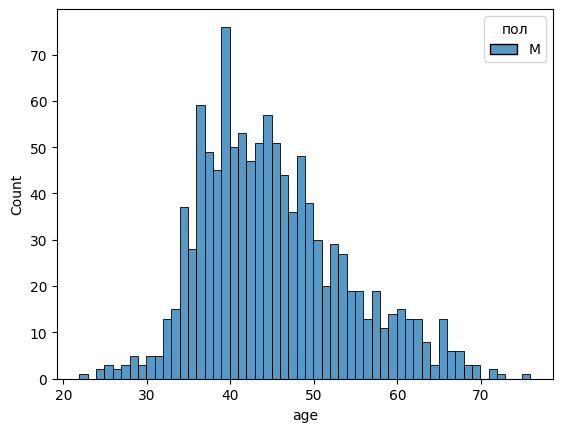

In [5]:
data['дата рождения'] = pd.to_datetime(data['дата рождения'])
data['date_now'] = pd.to_datetime("2024-01-01")
data['age'] = (data['date_now'] - data['дата рождения']) / np.timedelta64(1, 'D') / 365.25
hp = sns.histplot(data=data, x='age', hue="пол", binwidth=1, multiple="stack")
figure = hp.get_figure()    
figure.savefig(f'{path_save}/age_hist.png')

In [ ]:
data_vred = data[data['Текущая основная вредность - Физические факторы'] == 'Ионизирующие излученияК, радиоактивные веществаК;']
hpv = sns.histplot(data=data_vred, x='age', hue="пол", binwidth=1, multiple="stack").set_title("Ионизирующие излучения")
figure = hpv.get_figure()    
figure.savefig(f'{path_save}/ion_age_hist.png')

In [ ]:
data_no_vred = data[data['Текущая основная вредность - Физические факторы'] != 'Ионизирующие излученияК, радиоактивные веществаК;']
hpv = sns.histplot(data=data_no_vred, x='age', hue="пол", binwidth=1, multiple="stack").set_title("Без ионизирующих излучений")
figure = hpv.get_figure()    
figure.savefig(f'{path_save}/no_ion_age_hist.png')

# Diseases statistics

In [ ]:
data['терапевт - код_заболевания'].replace({None: 'Healthy'}, inplace=True)

subsets = {
    'Все данные': data.index.values,
    'Женщины': data.index[data['пол'] == 'Ж'].values,
    'Мужчины': data.index[data['пол'] == 'М'].values,
    'Ионизирующие излучения': data.index[data['Текущая основная вредность - Физические факторы'] == 'Ионизирующие излученияК, радиоактивные веществаК;'].values,
    'Ионизирующие излучения\nЖенщины': data.index[(data['Текущая основная вредность - Физические факторы'] == 'Ионизирующие излученияК, радиоактивные веществаК;') & (data['пол'] == 'Ж')].values,
    'Ионизирующие излучения\nМужчины': data.index[(data['Текущая основная вредность - Физические факторы'] == 'Ионизирующие излученияК, радиоактивные веществаК;') & (data['пол'] == 'М')].values,
    'Нет излучения': data.index[data['Текущая основная вредность - Физические факторы'] != 'Ионизирующие излученияК, радиоактивные веществаК;'].values,
    'Нет излучения\nЖенщины': data.index[(data['Текущая основная вредность - Физические факторы'] != 'Ионизирующие излученияК, радиоактивные веществаК;') & (data['пол'] == 'Ж')].values,
    'Нет излучения\nМужчины': data.index[(data['Текущая основная вредность - Физические факторы'] != 'Ионизирующие излученияК, радиоактивные веществаК;') & (data['пол'] == 'М')].values,
}

In [ ]:
statuses = np.concatenate(data['терапевт - код_заболевания'].str.split(';').values)
statuses = statuses[statuses != '']
statuses_counter = Counter(statuses)
df_statuses_counter = pd.DataFrame.from_dict(statuses_counter, orient='index', columns=['Count'])
df_statuses_counter.sort_values(['Count'], ascending=[False], inplace=True)
colors = distinctipy.get_colors(df_statuses_counter.shape[0], [mcolors.hex2color(mcolors.CSS4_COLORS['white']), mcolors.hex2color(mcolors.CSS4_COLORS['black'])], rng=1337)
colors_statuses = {status: colors[status_id] for status_id, status in enumerate(df_statuses_counter.index.values)}

In [ ]:
sns.set_theme(style='ticks')
fig, axs = plt.subplots(1, 9, figsize=(30, 20), gridspec_kw={'wspace':0.4},sharey=False, sharex=False)

for subset_id, (subset, subset_ids) in enumerate(subsets.items()):
    df_data_subset = data.loc[subset_ids, :]
    print(f"{subset}: {len(df_data_subset)}")
    statuses = np.concatenate(df_data_subset['терапевт - код_заболевания'].str.split(';').values)
    statuses = statuses[statuses != '']
    statuses_counter = Counter(statuses)
    df_statuses_counter = pd.DataFrame.from_dict(statuses_counter, orient='index', columns=['Count'])
    df_statuses_counter.sort_values(['Count'], ascending=[False], inplace=True)

    df_fig = df_statuses_counter.head(50)
    df_fig['Status'] = df_fig.index.values
    barplot = sns.barplot(
        data=df_fig,
        x='Count',
        y='Status',
        hue='Status',
        palette=colors_statuses,
        edgecolor='black',
        dodge=False,
        ax=axs[subset_id]
    )
    for container in barplot.containers:
        barplot.bar_label(container, label_type='edge', fmt='%.d', fontsize=12, padding=2.0)
    axs[subset_id].set_title(subset, fontsize='large')
    axs[subset_id].set_ylabel('')
    axs[subset_id].get_legend().remove()
plt.savefig(f"{path_save}/barplot_icd.png", bbox_inches='tight', dpi=200)
plt.savefig(f"{path_save}/barplot_icd.pdf", bbox_inches='tight')
plt.close(fig)